In [29]:
#Data handling
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
# use the inline backend to generate the plots within the browser
%matplotlib inline 

In [2]:
#Loading datasets

df_beauty=pd.read_json('data/ref/All_Beauty_5.json', lines=True)
df_appliances=pd.read_json('data/ref/Appliances_5.json', lines=True)
meta_data=pd.read_json('data/ref/meta_data.json', lines=True)

Compared to the discovery phase, let's try to go further into the anlysis of the data, but let's aim at no modifying the data for now. The goal here is to list the actions that will need to be performed to clean the data and to identify the good features candidates

# Meta Data Analysis

In [3]:
meta_data[['asin','description','title','date','brand']].describe(include='all')
#The other columns are causing issues because they contain list

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


,asin,description,title,date,brand
count,18772,5130,18771,18588,18295
unique,18521,4437,18417,3042,5785
top,B00008SCF5,[],onepix Hard Case for MacBook,2016-06-16 00:00:00,HP
freq,2,122,7,404,212
first,NaN,NaN,NaN,1973-09-04 00:00:00,NaN
last,NaN,NaN,NaN,2019-01-08 00:00:00,NaN


## Duplicates

Let's check if the duplicates are true duplicates i.e same ID, description and title

In [4]:
duplicates=meta_data[['asin','description','title']]
duplicates.head()

,asin,description,title
0,0321732960,[Brand new. Still in factory-sealed plastic.],Kelby Training DVD: The Adobe Photoshop CS5 7-...
1,0321735722,[If you're already a Photoshop user and want a...,Kelby Training DVD: Adobe Photoshop CS5 Power ...
2,0439651859,[School To Home Notes: Note From the Teacher!\...,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...
3,0545729971,[Dooqi is a young brand specializing in high-e...,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre..."
4,0594450284,[Cover for Nook HD],Hd+ Cheetah Cover- Nook


The descriptions are between brackets. This is causing an issue as well, let's remove them.

In [5]:
duplicates['description']=duplicates['description'].apply(lambda x: x[0] if isinstance(x,list) else str(x))
duplicates.head(3)

C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,asin,description,title
0,0321732960,Brand new. Still in factory-sealed plastic.,Kelby Training DVD: The Adobe Photoshop CS5 7-...
1,0321735722,If you're already a Photoshop user and want a ...,Kelby Training DVD: Adobe Photoshop CS5 Power ...
2,0439651859,School To Home Notes: Note From the Teacher!\n...,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...


In [6]:
duplicates['description'].describe()

count     18772
unique     4192
top         nan
freq      13642
Name: description, dtype: object

In [7]:
duplicates[pd.isnull(duplicates['description'])] #Checking the nan values

,asin,description,title


In [8]:
duplicates[duplicates['description']=="nan"]

,asin,description,title
7,0879394021,nan,Fire Detection & Suppression Systems 4e USB St...
12,1616830867,nan,Airflow Lap Top Lap Desk
14,1848494483,nan,"Music Theory Past Papers 2012, ABRSM Grade 1 (..."
18,7884139057,nan,uxcell Flexible Neck Black Three Blade Compute...
19,9178910897,nan,"IKEA - UPPTÄCKA Backpack, dark gray, yellow-or..."
...,...,...,...
18766,B01HI76P24,nan,TURNMEON Smart Watch for Kids Children Smartwa...
18767,B01HI72XZW,nan,"iPad Mini 4 Case, Aceguarder New Design [Dirtp..."
18768,B01HIEI83Q,nan,MIJIU Nylon Canvas Military Tactical Men Waist...
18770,B01HIWBL46,nan,Funnel Cup (Ultra Pink)


Most of the descriptions are empty and are represented by a string "nan" and not by numpy NaN.

In [9]:
cnt=duplicates[['asin','description']].groupby('asin').count()
cnt.head()

,description
asin,
0321732960,1
0321735722,1
0439651859,1
0545729971,1
0594450284,1


In [10]:
cnt.columns

Index(['description'], dtype='object')

In [11]:
cnt=cnt.rename(columns={'description':'cnt'})
cnt[cnt['cnt']>1].head()

,cnt
asin,
B00001MXZ7,2
B00003Q09I,2
B00004SYNG,2
B00004SYNK,2
B00004TEBU,2


In [12]:
cnt.shape

(18521, 1)

In [13]:
cnt[cnt['cnt']>2].head()

,cnt
asin,


There is no asin ID that is in the dataset more than twice

In [14]:
cnt=cnt.reset_index()
#cnt=cnt.drop('level_0', axis=1)
cnt.head()

,asin,cnt
0,0321732960,1
1,0321735722,1
2,0439651859,1
3,0545729971,1
4,0594450284,1


In [15]:
print('cnt dtypes:')
print(cnt.dtypes)
print('----------------')
print('duplicates dtypes:')
print(duplicates.dtypes)

cnt dtypes:
asin    object
cnt      int64
dtype: object
----------------
duplicates dtypes:
asin           object
description    object
title          object
dtype: object


In [16]:
duplicates=duplicates.merge(cnt, on='asin',how='left')
duplicates.head()

,asin,description,title,cnt
0,0321732960,Brand new. Still in factory-sealed plastic.,Kelby Training DVD: The Adobe Photoshop CS5 7-...,1
1,0321735722,If you're already a Photoshop user and want a ...,Kelby Training DVD: Adobe Photoshop CS5 Power ...,1
2,0439651859,School To Home Notes: Note From the Teacher!\n...,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...,1
3,0545729971,Dooqi is a young brand specializing in high-en...,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre...",1
4,0594450284,Cover for Nook HD,Hd+ Cheetah Cover- Nook,1


In [17]:
duplicates=duplicates[duplicates['cnt']>1]
duplicates.head(10)

,asin,description,title,cnt
38,B00001MXZ7,The EO2010 21-inch (20.1-inch viewable) displa...,"Princeton Eo2010 21"" Monitor (Pc/Mac)",2
39,B00003Q09I,The ViewSonic GS790 Short Neck 19-inch monitor...,"Viewsonic Gs790 19"" Short Neck Monitor (Pc/Mac)",2
40,B00004SYNG,NEC's AccuSync line of monitors is the company...,"NEC AccuSync 50 15"" Monitor (PC/Mac)",2
41,B00004SYNK,If you're looking to move on from a teeny-tiny...,"NEC AccuSync 90 19"" Monitor (PC/Mac)",2
42,B00004TEBU,The Viking IntelliFlash USB flash memory reade...,Test Big Data 9658,2
43,B00004TS2P,The ViewSonic E-790 19-inch monitor provides c...,"ViewSonic E790 19"" Monitor",2
44,B00004TS2Q,The ViewSonic E-790B 19-inch monitor provides ...,"ViewSonic E-790B 19"" Monitor",2
45,B00004TS2O,The Optiquest Q-95 19-inch CRT monitor with Pe...,"Optiquest Q-95 19"" Monitor",2
46,B00004WLQC,nan,"Philips 17"" 107P Professional Series Monitor",2
47,B00004Y74O,The NEC MultiSync FE950 monitor features NEC's...,"NEC MultiSync FE950 Totally Flat 19"" Monitor (...",2


In [18]:
duplicates.shape[0]

502

In [19]:
duplicates.reset_index(inplace=True)
duplicates.drop('cnt',axis=1,inplace=True)
duplicates.drop(['index'],axis=1,inplace=True)
#duplicates=duplicates[['asin','title','description']]
duplicates.head(10)

,asin,description,title
0,B00001MXZ7,The EO2010 21-inch (20.1-inch viewable) displa...,"Princeton Eo2010 21"" Monitor (Pc/Mac)"
1,B00003Q09I,The ViewSonic GS790 Short Neck 19-inch monitor...,"Viewsonic Gs790 19"" Short Neck Monitor (Pc/Mac)"
2,B00004SYNG,NEC's AccuSync line of monitors is the company...,"NEC AccuSync 50 15"" Monitor (PC/Mac)"
3,B00004SYNK,If you're looking to move on from a teeny-tiny...,"NEC AccuSync 90 19"" Monitor (PC/Mac)"
4,B00004TEBU,The Viking IntelliFlash USB flash memory reade...,Test Big Data 9658
5,B00004TS2P,The ViewSonic E-790 19-inch monitor provides c...,"ViewSonic E790 19"" Monitor"
6,B00004TS2Q,The ViewSonic E-790B 19-inch monitor provides ...,"ViewSonic E-790B 19"" Monitor"
7,B00004TS2O,The Optiquest Q-95 19-inch CRT monitor with Pe...,"Optiquest Q-95 19"" Monitor"
8,B00004WLQC,nan,"Philips 17"" 107P Professional Series Monitor"
9,B00004Y74O,The NEC MultiSync FE950 monitor features NEC's...,"NEC MultiSync FE950 Totally Flat 19"" Monitor (..."


In [20]:
duplicates['asin'].value_counts()

B0003QP0Q0    2
B000185ALA    2
B000234O3E    2
B0002ILK5E    2
B00006LHEM    2
             ..
B00008YGON    2
B000069BJJ    2
B00007M5VL    2
B0002EBF3K    2
B00008KJ2G    2
Name: asin, Length: 251, dtype: int64

In [21]:
temp=pd.Series(['-']*duplicates.shape[0])
duplicates['identifier']=duplicates['asin'].str.cat(temp.str.cat(duplicates['title']))
#duplicates.drop(['asin','title'], axis=1, inplace=True)
true_duplicates=duplicates.drop(['asin','title'], axis=1).groupby(['identifier']).count()
true_duplicates.head()

,description
identifier,
"B00001MXZ7-Princeton Eo2010 21"" Monitor (Pc/Mac)",2
"B00003Q09I-Viewsonic Gs790 19"" Short Neck Monitor (Pc/Mac)",2
"B00004SYNG-NEC AccuSync 50 15"" Monitor (PC/Mac)",2
"B00004SYNK-NEC AccuSync 90 19"" Monitor (PC/Mac)",2
B00004TEBU-Test Big Data 9658,2


In [22]:
true_duplicates.shape

(251, 1)

In [23]:
true_duplicates.rename(columns={'description':'cnt'}, inplace=True)
true_duplicates=true_duplicates[true_duplicates['cnt']>1]
true_duplicates.reset_index(inplace=True)

In [24]:
print('# duplicates:', duplicates['asin'].value_counts())
print('-----------------------')
print('# true duplicates:', true_duplicates['identifier'].value_counts())

# duplicates: B0003QP0Q0    2
B000185ALA    2
B000234O3E    2
B0002ILK5E    2
B00006LHEM    2
             ..
B00008YGON    2
B000069BJJ    2
B00007M5VL    2
B0002EBF3K    2
B00008KJ2G    2
Name: asin, Length: 251, dtype: int64
-----------------------
# true duplicates: B0003099MC-VIEWSONIC TPCV1250S PM-1G 40GB ( TPCV1250S-1003 )                                                                  1
B00021LKCY-Lian Li EX-23 HDD Module Silver.                                                                                   1
B00008BB5L-Sanwa 3.5-Inch Cleaning Diskette                                                                                   1
B0002Z7ZM4-Tonino Lamborghini Piazza Del Campidoglio Hard Shell Aluminum Laptop Case - Carrying case                          1
B00015GYNG-Hitachi MD1GBA 1 GB MicroDrive with Travel Kit                                                                     1
                                                                                         

All the 502 duplicates are true duplicates i.e same ID and same title

## image, brand, rank, main_cat

In [25]:
market=meta_data[['asin','image','brand','rank','main_cat']]
market.head(10)

,asin,image,brand,rank,main_cat
0,0321732960,[https://images-na.ssl-images-amazon.com/image...,Kelby Training,"[>#654,681 in Electronics (See Top 100 in Elec...",Computers
1,0321735722,[https://images-na.ssl-images-amazon.com/image...,Kelby Training,"[>#830,165 in Electronics (See Top 100 in Elec...",Computers
2,0439651859,[https://images-na.ssl-images-amazon.com/image...,TEACHERS FRIEND,"[>#1,233,887 in Electronics (See Top 100 in El...",Computers
3,0545729971,[https://images-na.ssl-images-amazon.com/image...,dooqi,"[>#454,595 in Electronics (See Top 100 in Elec...",Computers
4,0594450284,NaN,Nook,"[>#85,661 in Computers & Accessories (See top ...",Computers
5,0594626412,[https://images-na.ssl-images-amazon.com/image...,Samsung,"[>#1,013,527 in Electronics (See Top 100 in El...",Computers
6,0594626730,[https://images-na.ssl-images-amazon.com/image...,Barnes and Noble,"[>#211,266 in Electronics (See Top 100 in Elec...",Computers
7,0879394021,NaN,IFSTA,"[>#1,376,546 in Electronics (See Top 100 in El...",Computers
8,0988576902,[https://images-na.ssl-images-amazon.com/image...,Enter The Arena,"[>#212,572 in Electronics (See Top 100 in Elec...",Computers
9,1400501784,[https://images-na.ssl-images-amazon.com/image...,Barnes &amp; Noble,"[>#39,745 in Computers & Accessories (See top ...",Computers


image and rank like descriptions are enclosed in lists

In [26]:
for i in range(4):
    print('Image: ',market['image'][i][0])
    print('Rank: ',market['rank'][i][0])
    

Image:  https://images-na.ssl-images-amazon.com/images/I/31IlLImCVJL._SS40_.jpg
Rank:  >#654,681 in Electronics (See Top 100 in Electronics)
Image:  https://images-na.ssl-images-amazon.com/images/I/31TvjSNbFwL._SS40_.jpg
Rank:  >#830,165 in Electronics (See Top 100 in Electronics)
Image:  https://images-na.ssl-images-amazon.com/images/I/31GI7SdbS7L._SS40_.jpg
Rank:  >#1,233,887 in Electronics (See Top 100 in Electronics)
Image:  https://images-na.ssl-images-amazon.com/images/I/515Ui20DGVL._SS40_.jpg
Rank:  >#454,595 in Electronics (See Top 100 in Electronics)


* The picture in itself does not necessary bring value but the presence or not of an image could play a role
* The rank should be cleaned and transformed into an integer or into a range (categorical variable)

In [27]:
market['image']=market['image'].apply(lambda x: x[0] if isinstance(x,list) else x)
market['rank']=market['rank'].apply(lambda x: x[0] if isinstance(x,list) else x)
market.head()

C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,asin,image,brand,rank,main_cat
0,0321732960,https://images-na.ssl-images-amazon.com/images...,Kelby Training,">#654,681 in Electronics (See Top 100 in Elect...",Computers
1,0321735722,https://images-na.ssl-images-amazon.com/images...,Kelby Training,">#830,165 in Electronics (See Top 100 in Elect...",Computers
2,0439651859,https://images-na.ssl-images-amazon.com/images...,TEACHERS FRIEND,">#1,233,887 in Electronics (See Top 100 in Ele...",Computers
3,0545729971,https://images-na.ssl-images-amazon.com/images...,dooqi,">#454,595 in Electronics (See Top 100 in Elect...",Computers
4,0594450284,NaN,Nook,">#85,661 in Computers & Accessories (See top 100)",Computers


In [28]:
market.describe(include='all')

,asin,image,brand,rank,main_cat
count,18772,14084,18295,18080,18772
unique,18521,12299,5785,17794,1
top,B00008SCF5,https://images-na.ssl-images-amazon.com/images...,HP,">#1,891,305 in Electronics (See Top 100 in Ele...",Computers
freq,2,33,212,2,18772


* Most items do have an image
* The category containing the most items is the computer category
* There are 17794 for 18772 items, so it is a good sign that the rank is usable

# date and price

In [71]:
value=meta_data[['asin','date','price']]
value.head()

,asin,date,price
0,0321732960,2011-12-02,NaN
1,0321735722,2011-11-07,NaN
2,0439651859,2007-06-06,NaN
3,0545729971,2014-12-05,NaN
4,0594450284,2013-09-11,NaN


In [34]:
value.describe(include='all')

,asin,date,price
count,18772,18588,2650
unique,18521,3042,1124
top,B00008SCF5,2016-06-16 00:00:00,$2.54
freq,2,404,160
first,NaN,1973-09-04 00:00:00,NaN
last,NaN,2019-01-08 00:00:00,NaN


In [35]:
value.dtypes

asin             object
date     datetime64[ns]
price            object
dtype: object

* Pandas did capture the date as dates
* It looks like the prices are stored as string.
* Most of the items do have a date but just a few have prices

Let's build some visualizations to get more insights

In [36]:
value['year']=value['date'].dt.year
value.head()

C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,asin,date,price,year
0,0321732960,2011-12-02,NaN,2011.0
1,0321735722,2011-11-07,NaN,2011.0
2,0439651859,2007-06-06,NaN,2007.0
3,0545729971,2014-12-05,NaN,2014.0
4,0594450284,2013-09-11,NaN,2013.0


In [37]:
value.dtypes

asin             object
date     datetime64[ns]
price            object
year            float64
dtype: object

In [43]:
value['year'].value_counts(dropna=False)

2016.0    5530
2015.0    4024
2014.0    2259
2013.0    1837
2012.0    1447
2017.0    1193
2011.0     484
2010.0     433
2009.0     220
2008.0     200
NaN        184
2007.0     159
2002.0     159
2004.0     132
2006.0     126
2018.0     100
2003.0      94
2001.0      88
2005.0      71
1999.0      24
2000.0       4
1973.0       2
2019.0       1
1994.0       1
Name: year, dtype: int64

In [41]:
value=value.astype({'year':'int32'}, errors='ignore')
value.head()

asin             object
date     datetime64[ns]
price            object
year            float64
dtype: object

In [44]:
x_year=value['year'].dropna()
x_year=x_year.astype({'year':'int32'}, errors='ignore')
x_year.dtypes

dtype('int32')

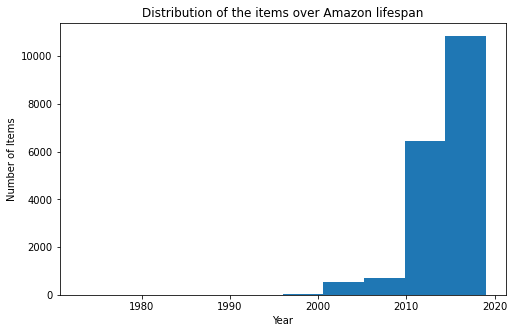

In [45]:
x_year.plot(kind='hist', figsize=(8, 5))

plt.title('Distribution of the items over Amazon lifespan') # add a title to the histogram
plt.ylabel('Number of Items') # add y-label
plt.xlabel('Year') # add x-label

plt.show()

This histogram suggests that we focus only on the items from the last decade for two reasons :
* The older data are probably less clean
* The dataset would be imbalance if we do not filter and we do use the date as a feature

In [46]:
value['price'].value_counts(dropna=False)

NaN       16122
$2.54       160
$9.99        89
$5.99        81
$5.39        70
          ...  
$4.16         1
$1.76         1
$13.67        1
$94.05        1
$6.58         1
Name: price, Length: 1125, dtype: int64

In [76]:
value['price']=value['price'].str.replace('$','')
value['price']=value['price'].str.replace(',','')
print(value['price'].dtypes)
value['price'].head(15)

object


C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6      8.99
7       NaN
8       NaN
9       NaN
10    16.99
11      NaN
12      NaN
13      NaN
14      NaN
Name: price, dtype: object

In [77]:
x_price=value['price'].dropna()
#x_price.value_counts(dropna=False)
x_price=x_price.astype('float64')
x_price.dtypes

ValueError: could not convert string to float: '16.18 - 42.22'

In [68]:
x_price.value_counts(dropna=False)

2.54      160
9.99       89
5.99       81
5.39       70
4.99       59
         ... 
58.99       1
10.69       1
108.13      1
8.55        1
25.19       1
Name: price, Length: 1124, dtype: int64

In [69]:
temp=x_price.apply(lambda x:x.isnumeric())
temp.value_counts()

False    2650
Name: price, dtype: int64

In [70]:
x_price.plot()
#kind='hist', figsize=(8, 5)
#plt.title('Price distribution of the items on Amazon') # add a title to the histogram
#plt.ylabel('Number of Items') # add y-label
#plt.xlabel('Price') # add x-label

#plt.show()

TypeError: no numeric data to plot

A lot of errors to solve for next time, converting the price to a number is more complicated than I initially thought. In particular the prices are presented as ranges sometimes and other time not.